## tensorflow hub

* 일반화된 문제들에 대해서 모델의 재사용성을 극대화하기 위해서 구글에서 공개한 API.

* 텐서플로우 1.7.0 버전 이상에서 사용

* 이점 
    1. 다양한 Pre-Trained 모델을 __모듈(Module) 형태__ 로 손쉽게 사용가능
    2. Pre-Trained 모델을 내가 풀고자하는 문제에 __Fine-Tuning__ 해서 최소한의 노력으로 실제문제를 해결할 수 있다.
    
* 모듈 import
    * URL 또는 filesystem path를 통하여, tensorflow hub module을 Module 객체 형태로 tensorflow program으로 import한다.
        * 예) m = hub.Module("path/to/a/module_dir")
        * 예) m = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
    * 이는, 모듈의 변수들을 현재 tensorflow graph로 추가 해준다. 
    * 모듈을 처음 다운 받을 때에는 시간이 걸리지만, 디폴트로 캐싱 되어서, 이후엔 빠름 
        * (https://www.tensorflow.org/hub/basics)
* 모듈 applying

### sentence encoder module

* word, sentence or paragraph를 512-d vector로 embedding
* 용도
    * for sentence similarity and sentence classification tasks.
* 장점
    * The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sklearn

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

In [3]:
# Import the Universal Sentence Encoder's TF Hub module
# This module is about 1GB. 
# Depending on your network speed, it might take a while to load the first time you run inference with it.
# After that, loading the model should be faster as modules are cached by default
# Further, once a module is loaded to memory, inference time should be relatively fast.
embed = hub.Module(module_url)

* word, sentence, paragraph 어떤 길이든 embedding 가능
    * 길어질수록 vector가 diluted 되긴 함

In [4]:
# Compute a representation for each message, showing various lengths supported.
# word, sentence, paragraph 모두 embedding 가능 
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(messages))
    
    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.016987269744277, -0.00894981063902378, -0.007062734104692936, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.035313352942466736, -0.025384267792105675, -0.00788002647459507, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [0.01879092864692211, 0.04536517709493637, -0.020010894164443016, ...]



### 유사도 계산 & 시각화

* Universal Sentence Encoder는 거의 정규화가 된 벡터 리턴. 따라서, 내적으로 바로 유사도 계산 가능

In [5]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

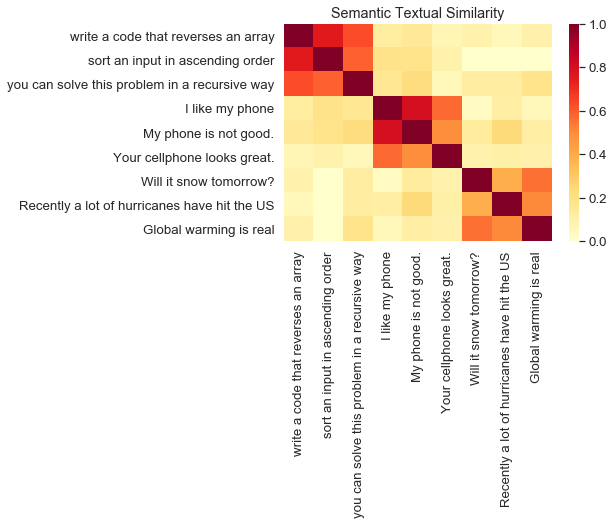

In [6]:
messages = [
    # programming
    "write a code that reverses an array",
    "sort an input in ascending order",
    "you can solve this problem in a recursive way",
    
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

#     # Food and health
#     "An apple a day, keeps the doctors away",
#     "Eating strawberries is healthy",
#     "Is paleo better than keto?",

#     # Asking about age
#     "How old are you?",
#     "what is your age?",
]
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

In [7]:
dataset = pd.read_csv('Total_data_original - 시트1.csv')

In [8]:
dataset.head()

,Assignee,Quesition_number,Category,loop,non-important,Recheck,Is_done,Original_Sentences,Unnamed: 8,Seperated_sentence
0,JS,1,AP-1,1,NaN,NaN,v,"Given an array of scores, return true if each ...",NaN,NaN
1,JS,2,AP-1,1,NaN,NaN,v,"Given an array of scores, return true if there...",NaN,NaN
2,JS,3,AP-1,1,NaN,NaN,v,Given an array of scores sorted in increasing ...,NaN,NaN
3,JS,4,AP-1,1,NaN,NaN,v,"Given an array of scores, compute the int aver...",NaN,NaN
4,JS,5,AP-1,1,NaN,NaN,v,"Given an array of strings, return the count of...",NaN,NaN


In [9]:
# for index, row in dataset.iterrows():
#     message_embeddings = session.run(row["Original_Sentences"])
#     print(index)
#     print("sentence : ", row["Original_Sentences"], "\nlabel : ", row["loop"])

#print(dataset["Original_Sentences"])
#print(dataset["loop"])

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(dataset["Original_Sentences"].tolist()))

In [10]:
#print(message_embeddings)
len(message_embeddings)

317

In [11]:
df = pd.DataFrame({"embedding" : message_embeddings.tolist(), "label" : dataset["loop"].tolist()})
df.to_csv("training_set.csv", mode = 'w')

In [12]:
df.head()

,embedding,label
0,"[0.021512700244784355, -0.022678228095173836, ...",1
1,"[-0.0012334657367318869, -0.033827848732471466...",1
2,"[-0.008798131719231606, -0.03114403784275055, ...",1
3,"[-0.03601554408669472, -0.04441244155168533, 0...",1
4,"[0.02412533015012741, -0.0021673801820725203, ...",1


In [13]:
df_loop = df.loc[df['label'] == 1]
print(df_loop.shape)

(167, 2)


In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)

1.14.0


In [15]:
from sklearn.model_selection import train_test_split
embeddings = np.array(message_embeddings)
labels = np.array(df['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.33)

### bulid a model

In [16]:
model = keras.Sequential([
    # 인풋 벡터는 512-d
    
    # 1. Dense layer = fully connected layer
    #    node 개수 : 128
    #    activation function : relu
    keras.layers.Dense(128, input_shape = (512,), activation=tf.nn.relu),
    
    # 2. 마지막 레이어
    #    node 개수 : 2 (= 클래스 개수)
    #    softMax : 2개의 확률 반환, 전체 합은 1
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #정확히 뭐냐_ 어떤 공식이냐;;  precision recall ..  false positive false negative.. 다 계산해야함.. 

### train a model

In [18]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
212/212 [==============================] - 1s 4ms/sample - loss: 0.6828 - acc: 0.5566
Epoch 2/10
212/212 [==============================] - 0s 46us/sample - loss: 0.6568 - acc: 0.5943
Epoch 3/10
212/212 [==============================] - 0s 42us/sample - loss: 0.6326 - acc: 0.7170
Epoch 4/10
212/212 [==============================] - 0s 42us/sample - loss: 0.6076 - acc: 0.7217
Epoch 5/10
212/212 [==============================] - 0s 42us/sample - loss: 0.5841 - acc: 0.7406
Epoch 6/10
212/212 [==============================] - 0s 42us/sample - loss: 0.5584 - acc: 0.7406
Epoch 7/10
212/212 [==============================] - 0s 45us/sample - loss: 0.5356 - acc: 0.7689
Epoch 8/10
212/212 [==============================] - 0s 47us/sample - loss: 0.5234 - acc: 0.7689
Epoch 9/10
212/212 [==============================] - 0s 43us/sample - loss: 0.5090 - acc: 0.7358
Epoch 10/10
212/212 [==============================] - 0s 44us/sample - loss: 0.4863 - acc: 0.8113


### test a model

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test accuracy :', test_acc)

105/105 [==============================] - 1s 8ms/sample - loss: 0.5095 - acc: 0.7714
test accuracy : 0.7714286


In [20]:
 
# Python program explaining 
# logical_and() function 
import numpy as np 
  
# input 
arr1 = [8, 2, False, 4] 
arr2 = [3, 0, True, False] 
  
# output 
out_arr = np.logical_and(arr1, arr2) 
  
print ("Output Array : ", out_arr) 

Output Array :  [ True False False False]


### predict  

In [23]:
y_predict = model.predict(X_test)

### confusion matrix

```
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
| TN(0을0으로맞춤) | FP(0을1이라함)|
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
| FN(1을0이라함)      | TP(1을1이라함)|
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
```

* Precision = TP / (FP + TP)   (손을 휘둘렀을때 모기가 있었냐)
* Recall = TP / (FN + TP)          (모기가 있을때 잘 잡느냐)
* F1 score = 2 * (Precision * recall) / (precision + recall)


In [27]:
len(y_predict)

105

In [34]:
index = 0

correct = [0,0]  # TN, TP
wrong = [0,0]   # FN, FP

for zero_prop, one_prop in y_predict:
    print(zero_prop, one_prop, end = '')
    predicted = 0 if zero_prop > one_prop else 1
    print(" | predicted label => ", predicted, end = '')
    true = y_test[index]
    print(" | true label => ", y_test[index])
    if true == predicted :
        correct[true] += 1
    else:
        wrong[predicted] += 1
    index += 1

0.7169363 0.28306368 | predicted label =>  0 | true label =>  0
0.64104944 0.35895056 | predicted label =>  0 | true label =>  0
0.46057707 0.5394229 | predicted label =>  1 | true label =>  1
0.34430462 0.65569544 | predicted label =>  1 | true label =>  0
0.34834474 0.65165526 | predicted label =>  1 | true label =>  1
0.43008244 0.5699175 | predicted label =>  1 | true label =>  0
0.9085565 0.09144342 | predicted label =>  0 | true label =>  0
0.73042756 0.2695724 | predicted label =>  0 | true label =>  1
0.514679 0.48532104 | predicted label =>  0 | true label =>  1
0.81674886 0.18325111 | predicted label =>  0 | true label =>  0
0.4354252 0.56457484 | predicted label =>  1 | true label =>  0
0.32423735 0.67576265 | predicted label =>  1 | true label =>  1
0.68115777 0.3188422 | predicted label =>  0 | true label =>  0
0.37377375 0.62622625 | predicted label =>  1 | true label =>  1
0.46161586 0.5383841 | predicted label =>  1 | true label =>  1
0.23753107 0.7624689 | predicted la

In [42]:
print('| TN = {0} | FP = {1} | \n| FN = {2} | TP = {3} |'.format(correct[0], wrong[1], wrong[0], correct[1]))

| TN = 38 | FP = 9 | 
| FN = 15 | TP = 43 |


In [43]:
TN = correct[0]; TP = correct[1]; FN = wrong[0]; FP = wrong[1];
precision = TP / (FP + TP)
recall = TP / (FN + TP)
print("precision = ", precision)
print("recall = ", recall)

precision =  0.8269230769230769
recall =  0.7413793103448276


In [44]:
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1_score = ", f1_score)

F1_score =  0.7818181818181817
